In [1]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from keyname import keyname as kn
from matplotlib import colors as mpl_colors
from teeplot import teeplot as tp

import Bio
import alifedata_phyloinformatics_convert as apc
import csv
import glob
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
import urllib.request as request
import io
from copy import deepcopy

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (15, 20)
plt.rcParams["font.size"] = 13
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams["lines.linewidth"] = 2
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

In [3]:
morphs = {x['stint']: x[' morph'][1:] for x in pd.read_csv('morphs_by_stint.csv').to_dict(orient='records')}

In [4]:
filenames = glob.glob("dump/stint=*/*/a=genome+criteria=abundance+*thread=0*.json")

In [5]:
stint_tags = {}
for filename in filenames:
    file_data = kn.unpack(filename)
    with open(filename, 'r') as file:
        data = json.load(file)
        data = data['value0']['event_tags']['tags']
        tags = [v['value0']['value0'] for k, v in data.items()]
        stint_tags[file_data['stint']] = tags
stint_tags = {int(k): v for k, v in stint_tags.items()}
stint_tags = dict(sorted(stint_tags.items()))
del stint_tags[101]
del stint_tags[102]

In [6]:
def hamming_distance(a, b):
    return (a ^ b).bit_count()

In [7]:
matrix = np.zeros((len(stint_tags), len(stint_tags)))
pairwise = itertools.combinations(list(stint_tags.keys()), 2)

for a, b in pairwise:
    matrix[a][b] = sum(hamming_distance(x, y) for x, y in zip(stint_tags[a], stint_tags[b]))

teeplots/./cmap=blues+linecolor=88888820+viz=heatmap+ext=.pdf
teeplots/./cmap=blues+linecolor=88888820+viz=heatmap+ext=.png


<AxesSubplot:>

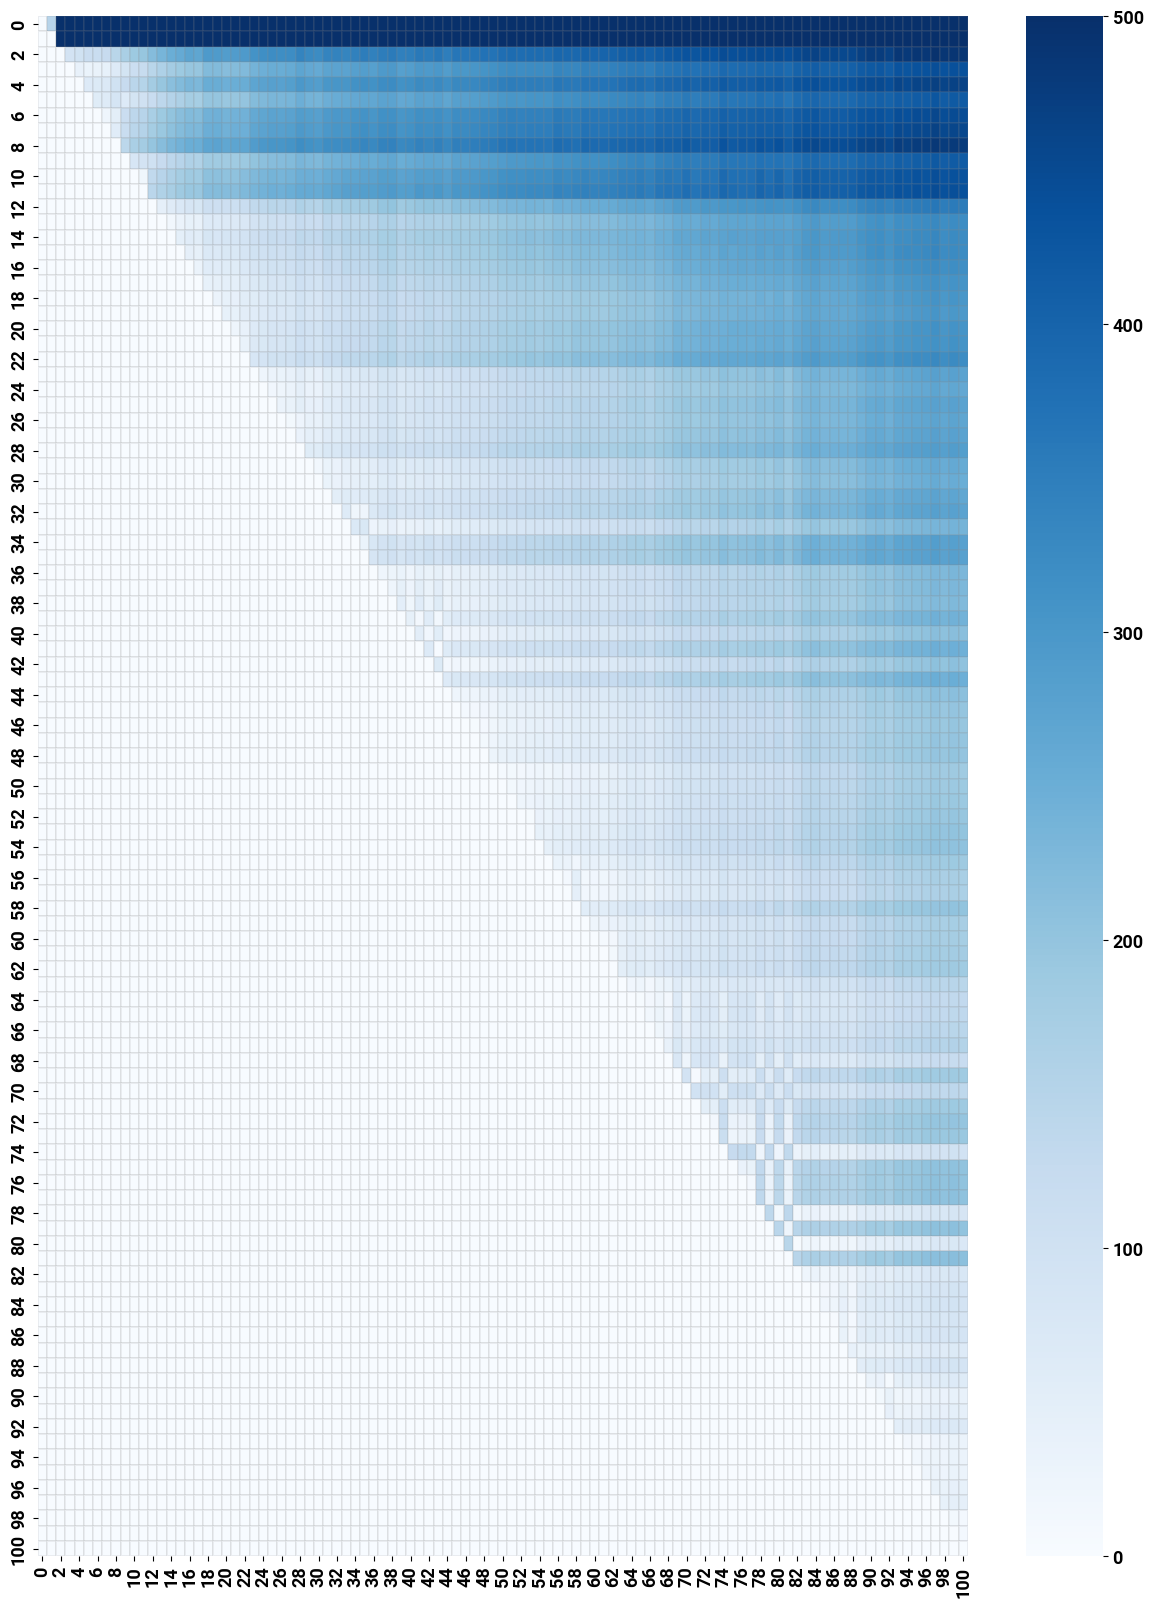

In [8]:
tp.tee(
    sns.heatmap,
    matrix,
    vmax=500,
    linewidths=0.05,
    linecolor='#88888820',
    cmap='Blues'
)

In [9]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0.0]
        for row_idx, row in enumerate(matrix.tolist())
    ]

def fix_branch_length(root):
    if 'Inner' not in root.name:
        root.branch_length = 1
    else:
        root.branch_length = sum([x.branch_length for x in root]) / len([x.branch_length for x in root])
    for x in root:
        fix_branch_length(x)

def find_leaves(root):
    nodes = []
    for node in root.clades:
        if 'label' in node.__dict__:
            if node.label is not None:
                nodes.append(node.label)
            nodes.extend(find_leaves(node))
        elif 'name' in node.__dict__:
            if node.name is not None:
                nodes.append(node.name)
            nodes.extend(find_leaves(node))
    return nodes



In [10]:
class MyTreeMixin(Bio.Phylo.BaseTree.TreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTreeMixin, self).__init__(*args, **kwargs)
    def fix_inner_nodes(self):
        leaves = find_leaves(self.root)
        if leaves:
            min_leaf = min(leaves, default='0')
            name = str(min_leaf)
            self.root.label = name
            for node in self.root.clades:
                node.__class__ = MyClade
                node.fix_inner_nodes()
    def sort_tree(self, reverse=False):
        self.root.clades.sort(key=lambda x: int("".join(filter(str.isdigit, x.name))), reverse=reverse)
        for node in self.root.clades:
            node.__class__ = MyClade
            node.sort_tree(reverse=reverse)            
class MyTree(Bio.Phylo.BaseTree.Tree, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTree, self).__init__(*args, **kwargs)
class MyClade(Bio.Phylo.BaseTree.Clade, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyClade, self).__init__(*args, **kwargs)

In [11]:
from collections import defaultdict
import dendropy
from nanto import nantonone

def scipy_linkage_matrix_to_dendropy_tree(
    matrix,
    leaf_taxon_labels = None,
):
    # scipy linkage format
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
    num_rows = len(matrix)

    # cluster id -> node
    nodes = defaultdict(dendropy.Node)

    if leaf_taxon_labels is not None:
        assert len(leaf_taxon_labels) == num_rows + 1
        for label, cluster_id in enumerate(leaf_taxon_labels):
            nodes[cluster_id].taxon = dendropy.Taxon(label=label)

    for row_idx, row in enumerate(matrix):
        parent_cluster = row_idx + num_rows + 1
        joined_cluster1, joined_cluster2, cluster_distance, cluster_size = row

        nodes[parent_cluster].cluster_id = parent_cluster
        nodes[row_idx].label = leaf_taxon_labels[row_idx]
        for child_cluster in joined_cluster1, joined_cluster2:
            nodes[parent_cluster].add_child(nodes[child_cluster])
            nodes[child_cluster].cluster_id = child_cluster
            nodes[child_cluster].edge_length = nantonone(cluster_distance / 2)

    return dendropy.Tree(seed_node=nodes[parent_cluster])

In [12]:
import opytional as opyt
from nanto import isanan

def dendropy_tree_to_alife_dataframe(
    tree,
    exportattrs = None,
):
    """Convert a dendropy phylogenetic tree to a dataframe formatted to the
    artificial life communit data format standards.
    The following Node object attributes will automatically be exported to
    dataframe columns, if available:
        * edge_length,
        * id,
        * label,
        * origin_time, and
        * taxon.label.
    Parameters
    ----------
    tree:
        dendropy tree to convert.
    exportattrs: optional
        Node attrs that should be copied as columns into the generated
        dataframe. If a map is provided, attr values in keys will be inserted
        into the dataframe with the corresponding value as the column name.
    """

    # set up node origin times if any edge lengths set
    if any(node.edge_length is not None for node in tree):
        if not hasattr(tree.seed_node, 'origin_time'):
            tree.seed_node.origin_time = opyt.or_value(
                tree.seed_node.edge_length,
                0
            )
        else:
            assert tree.seed_node.origin_time is not None
        for node in tree:
            parent = node.parent_node
            if parent is not None and not hasattr(node, 'origin_time'):
                if None not in (
                    getattr(parent, 'origin_time', None),
                    node.edge_length,
                ) and not isanan(parent.origin_time):
                    node.origin_time = parent.origin_time + node.edge_length

    # attach ids to nodes, if needed
    for fallback_id, node in enumerate(tree):
        if not hasattr(node, 'id'):
            node.id = fallback_id
        else:
            assert isinstance(node.id, int)

    assert not any((
        attr in opyt.or_value(exportattrs, [])
        for attr
        in ('origin_time', 'id', 'edge_length', 'label', 'taxon.label')
    ))
    return pd.DataFrame.from_records([
        {
            **{
                'id': node.id,
                'ancestor_list': str(
                    [opyt.apply_if(node.parent_node, lambda x: x.id)]
                ),
                'origin_time': getattr(node, 'origin_time', None),
                'edge_length': node.edge_length,
                'label': node.label,
                'name': node.label,
                'taxon_label': opyt.apply_if(node.taxon, lambda x: x.label),
            },
            **{
                exportattrs[attr_name]
                if isinstance(exportattrs, Mapping)
                else attr_name: _rgetattr(node, attr_name)
                for attr_name in opyt.or_value(exportattrs, [])
            },
        }
        for node in tree
    ])

In [13]:
linkage_matrix = sci.cluster.hierarchy.linkage(matrix)

In [14]:
dendropy_tree = scipy_linkage_matrix_to_dendropy_tree(
    linkage_matrix,
    leaf_taxon_labels=['{} ({})'.format(str(x), morphs[x]) for x in range(len(linkage_matrix) + 1)]
)

In [15]:
df = apc.dendropy_tree_to_alife_dataframe(dendropy_tree)

In [16]:
tree = apc.alife_dataframe_to_biopython_tree(df, ['label'])

In [17]:
def print_tree(root):
    print(root.__dict__)
    for node in root:
        print_tree(node)

def set_color(x):
    if x:
        return mpl_colors.to_hex('C' + str(ord(x[-2]) - ord('a')))

In [18]:
new_tree = MyTree(root=tree.clade)
new_tree.fix_inner_nodes()
new_tree.draw_only_terminal_nodes()
# new_tree.sort_tree(reverse=False)
print_tree(new_tree.clade)

{'branch_length': None, 'name': None, 'clades': [MyClade(id=1, label='0 (a)', origin_time=3824.5671650527984), MyClade(id=4, label='10 (b)', origin_time=3824.5671650527984)], 'confidence': None, '_color': None, 'width': None, 'id': 0, 'label': '0 (a)', 'origin_time': 0.0}
{'branch_length': None, 'name': None, 'clades': [MyClade(id=2, label='0 (a)', origin_time=3903.231006809987), MyClade(id=3, label='1 (b)', origin_time=3903.231006809987)], 'confidence': None, '_color': None, 'width': None, 'id': 1, 'label': '0 (a)', 'origin_time': 3824.5671650527984}
{'branch_length': None, 'name': None, 'clades': [], 'confidence': None, '_color': None, 'width': None, 'id': 2, 'label': '0 (a)', 'origin_time': 3903.231006809987}
{'branch_length': None, 'name': None, 'clades': [], 'confidence': None, '_color': None, 'width': None, 'id': 3, 'label': '1 (b)', 'origin_time': 3903.231006809987}
{'branch_length': None, 'name': None, 'clades': [MyClade(id=5, label='12 (b)', origin_time=4137.762391708634), MyC

In [ ]:
tp.tee(
    Phylo.draw,
    new_tree,
    label_func=lambda x: if x.is_terminal(): x.label,
    branch_labels=None,
#     label_colors=lambda x: set_color(x),
#     xlabel=["point mutation distance"],
#     ylabel=[""],
#     yticks={"ticks": [0]},
#     grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)

## parsimony tree stuff

In [20]:
scorer = Phylo.TreeConstruction.ParsimonyScorer()

In [21]:
searcher = Phylo.TreeConstruction.NNITreeSearcher(scorer)

In [22]:
dm = Bio.Phylo.TreeConstruction.DistanceMatrix(
    names=[str(x) for x in range(len(stint_tags))],
    matrix=to_tril(matrix.T)
)
# tree = getattr(DistanceTreeConstructor(), 'upgma')(dm)
tree = getattr(DistanceTreeConstructor(), 'nj')(dm)


In [23]:
tree

Tree(rooted=False)

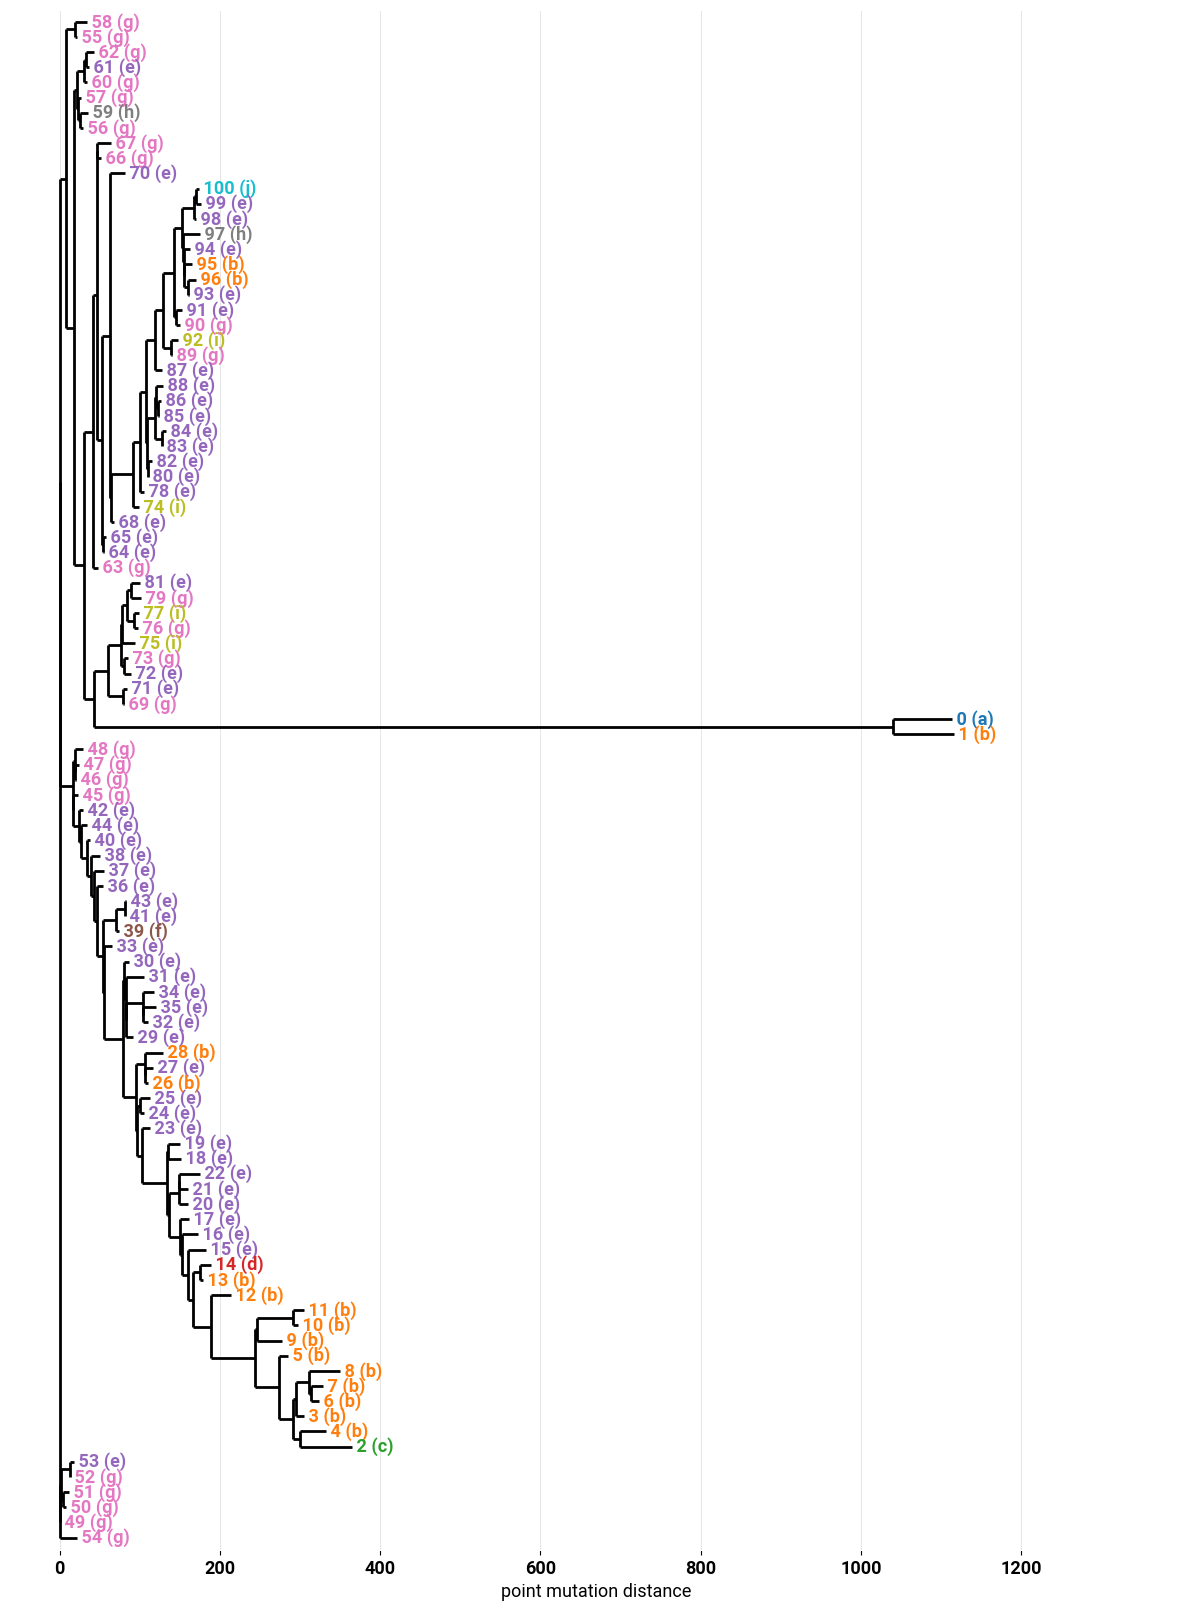

teeplots/./viz=draw+ext=.pdf
teeplots/./viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [24]:
tp.tee(
    Phylo.draw,
    tree,
#     tree,
    label_func=lambda x: str(x) + " (" + morphs[int(x.name)] + ")" if 'Inner' not in str(x) else None,
    branch_labels=None,
    label_colors=lambda x: set_color(x),
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)

In [25]:
bigtags_per_stint = {}

for stint, tags in stint_tags.items():
    bigtag = ''.join(bin(x)[2:].zfill(64) for x in tags)
    bigtags_per_stint[stint] = bigtag

In [26]:
# base_map = {
#     '00': 'A',
#     '01': 'C',
# }

align_str = f"""{len(bigtags_per_stint)} {len(bigtags_per_stint[0])}
"""

for stint, bigtag in bigtags_per_stint.items():
    align_str += str(stint).zfill(10) + str(bigtag) + "\n"

In [27]:
f = io.StringIO(align_str)

In [28]:
from Bio import AlignIO
aln = AlignIO.read(f, 'phylip')
aln

<<class 'Bio.Align.MultipleSeqAlignment'> instance (101 records of length 2240) at 7f3c62969d80>

In [29]:
def rename_tree(root):
    try:
        stint_id = int(root.name)
        root.name = str(stint_id).zfill(10)
    except (ValueError, TypeError):
        pass
    for node in root.clades:
        rename_tree(node)

In [30]:
fixed_tree = deepcopy(tree)
rename_tree(fixed_tree.clade)

In [31]:
print(fixed_tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner99')
        Clade(branch_length=0.6177946053621213, name='Inner97')
            Clade(branch_length=6.983686854672722, name='Inner90')
                Clade(branch_length=11.141111256494288, name='Inner88')
                    Clade(branch_length=15.997494921088222, name='0000000058')
                    Clade(branch_length=3.0025050789117778, name='0000000055')
                Clade(branch_length=10.936845896826025, name='Inner87')
                    Clade(branch_length=3.8124885884831556, name='Inner86')
                        Clade(branch_length=8.603913275258883, name='Inner83')
                            Clade(branch_length=1.9037726135814914, name='Inner82')
                                Clade(branch_length=9.67967383066813, name='0000000062')
                                Clade(branch_length=3.320326169331871, name='0000000061')
                            Clade(branch_length=3.0962273864185086, name='0000000060')


In [32]:
constructor = Phylo.TreeConstruction.ParsimonyTreeConstructor(searcher, fixed_tree)

In [33]:
pars_tree = constructor.build_tree(aln)

In [34]:
print(pars_tree)

Tree(rooted=True)
    Clade(branch_length=0)
        Clade(branch_length=664.2594759716598, name='Inner1')
            Clade(branch_length=75.81818181818176, name='0000000001')
            Clade(branch_length=74.18181818181824, name='0000000000')
        Clade(branch_length=332.46297515888944, name='Inner76')
            Clade(branch_length=13.27006011169033, name='Inner81')
                Clade(branch_length=11.651452508776366, name='Inner87')
                    Clade(branch_length=10.936845896826025, name='Inner90')
                        Clade(branch_length=6.983686854672722, name='Inner97')
                            Clade(branch_length=0.6177946053621213, name='Inner99')
                                Clade(branch_length=22.27000529319048, name='0000000054')
                                Clade(branch_length=0.22999470680952072, name='Inner98')
                                    Clade(branch_length=0.4762696102261543, name='0000000049')
                                    C

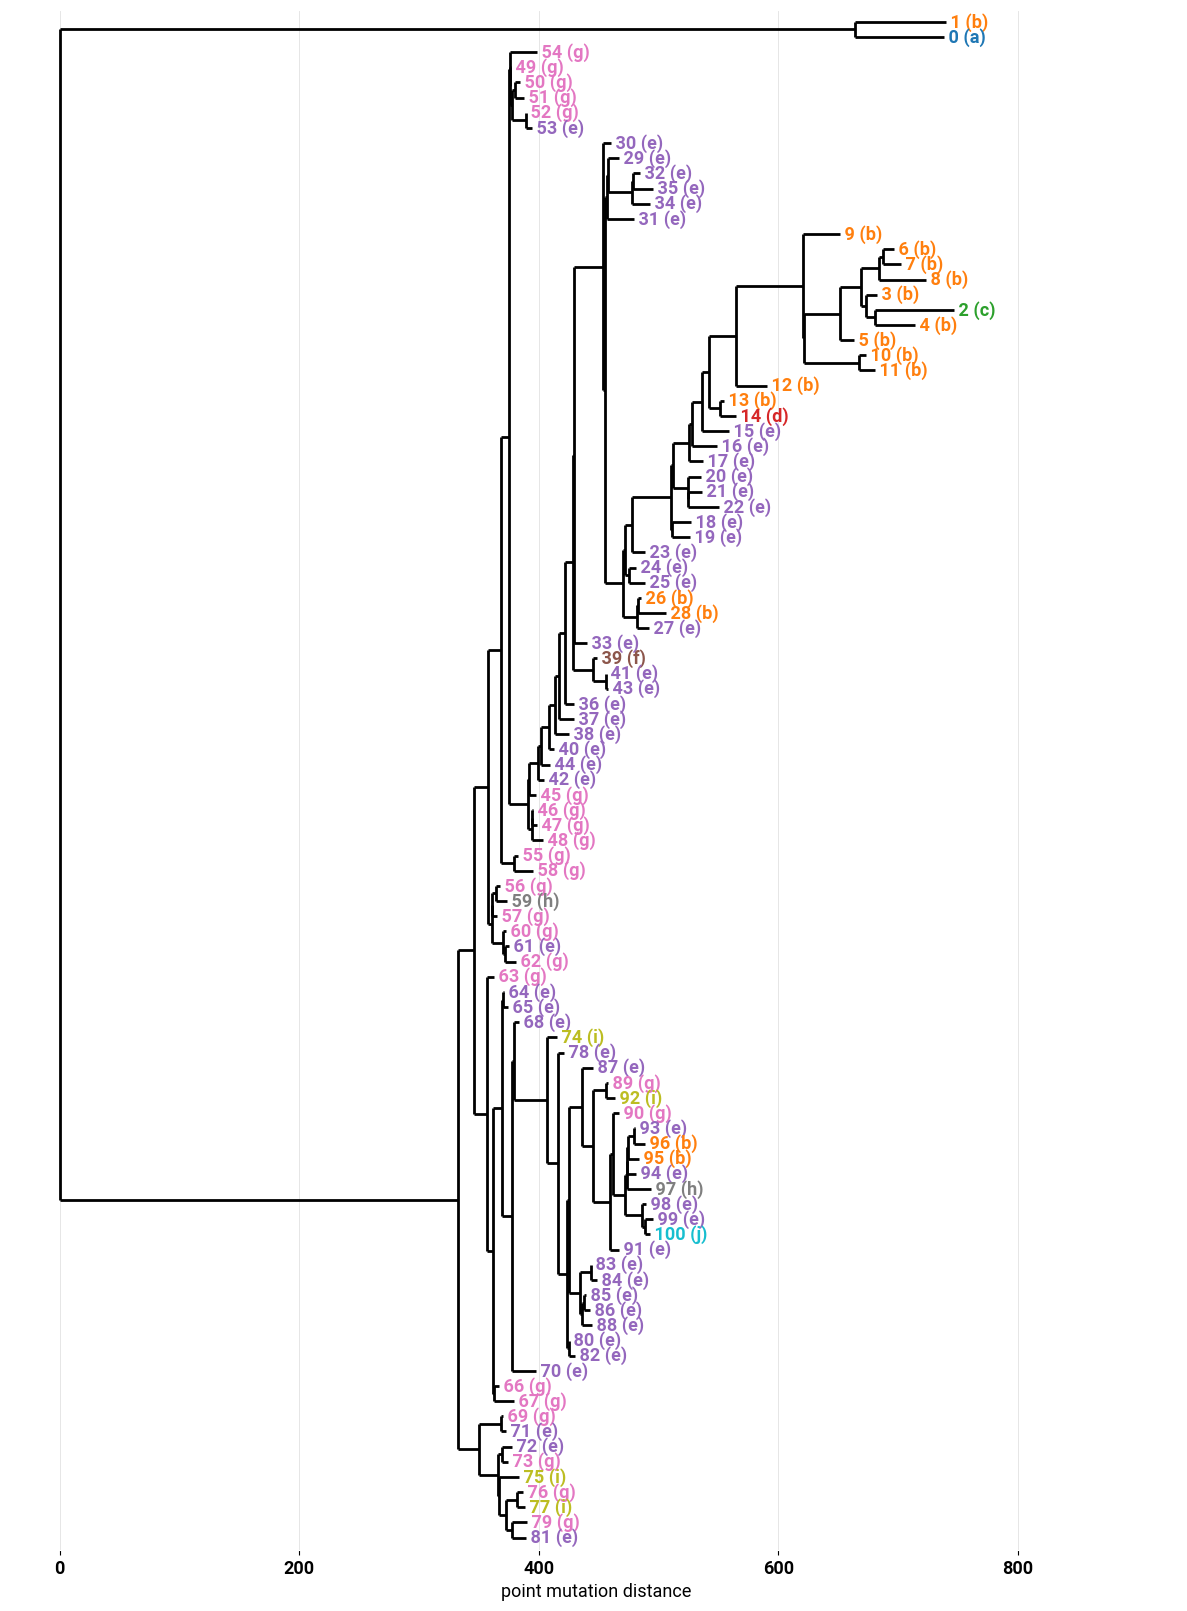

teeplots/./viz=draw+ext=.pdf
teeplots/./viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [35]:
def name_function(node):
    try:
        return str(int(node.name)) + " (" + morphs[int(node.name)] + ")" if 'Inner' not in str(node) else None
    except TypeError:
        return ""
    
tp.tee(
    Phylo.draw,
    pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)

In [36]:
sorted_pars_tree = deepcopy(pars_tree)
sorted_pars_tree = MyTree(sorted_pars_tree.clade)
sorted_pars_tree.sort_tree(reverse=True)

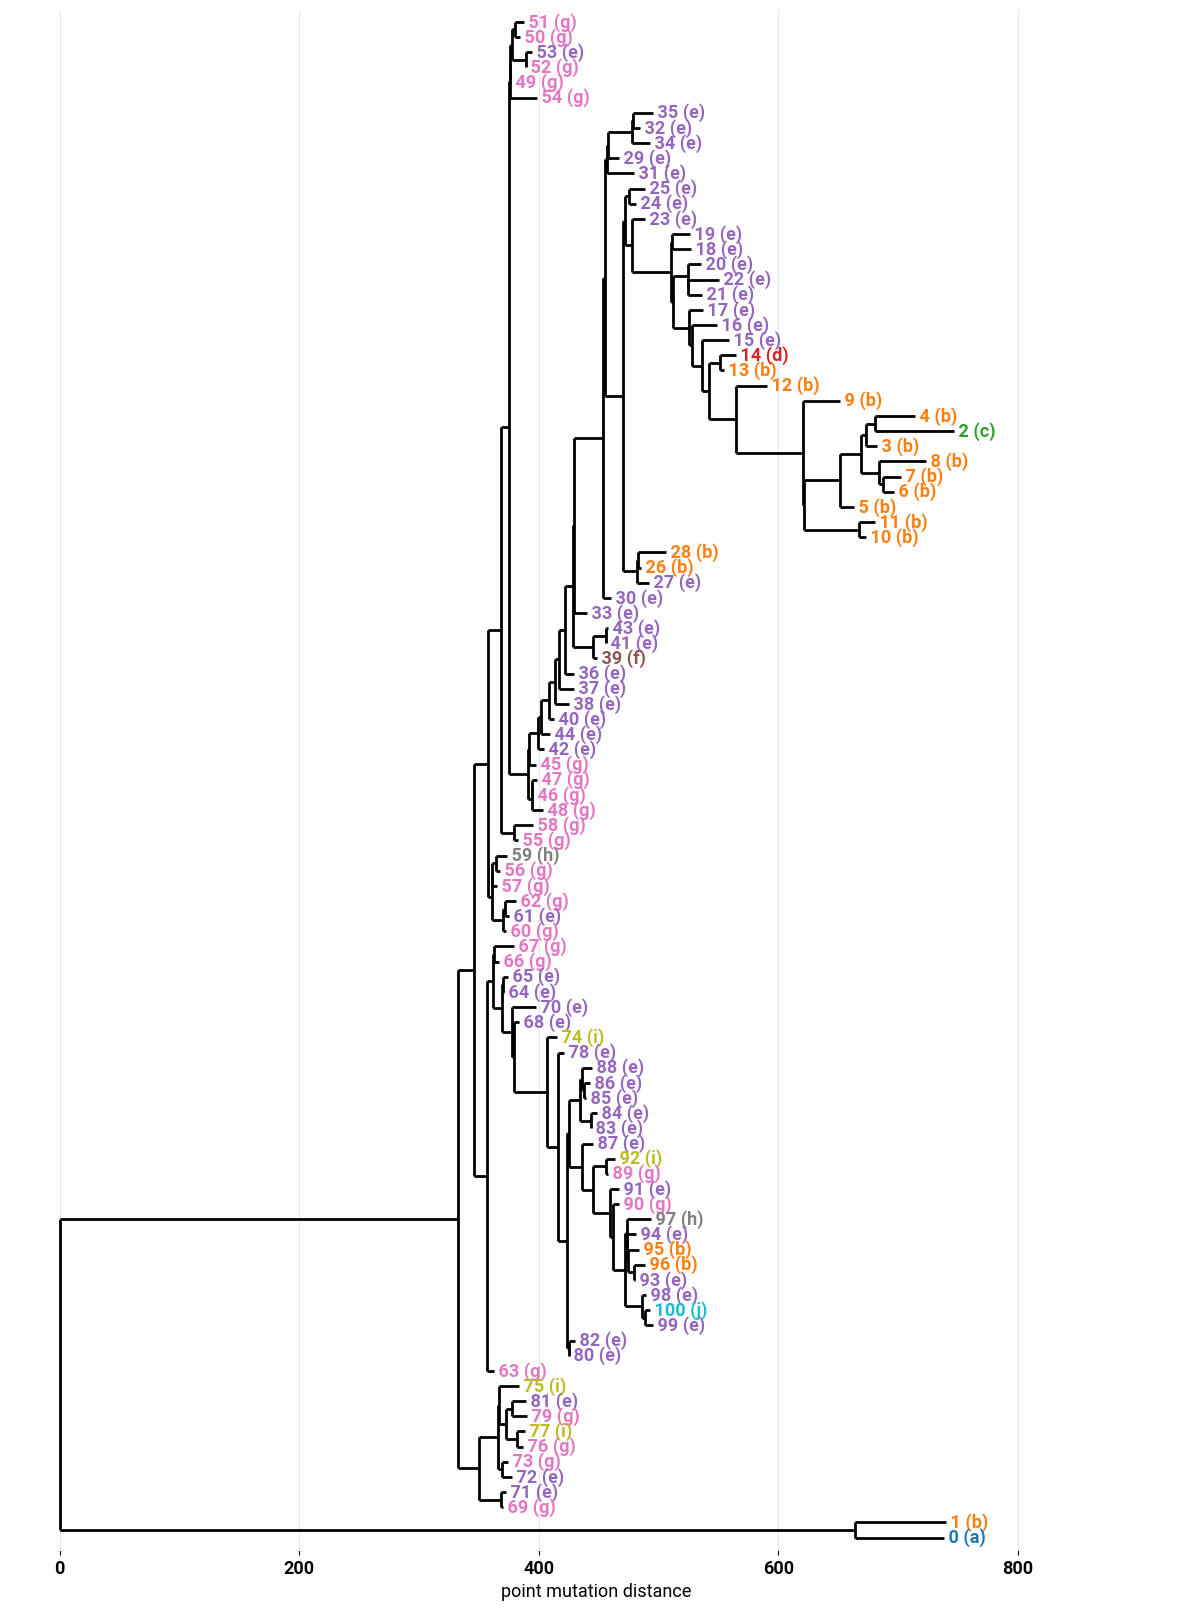

teeplots/./viz=draw+ext=.pdf
teeplots/./viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [37]:
tp.tee(
    Phylo.draw,
    sorted_pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)

In [47]:
rerooted_pars_tree = deepcopy(sorted_pars_tree)
rerooted_pars_tree.root_with_outgroup({"name": "0000000002"})
rerooted_pars_tree.sort_tree(reverse=True)

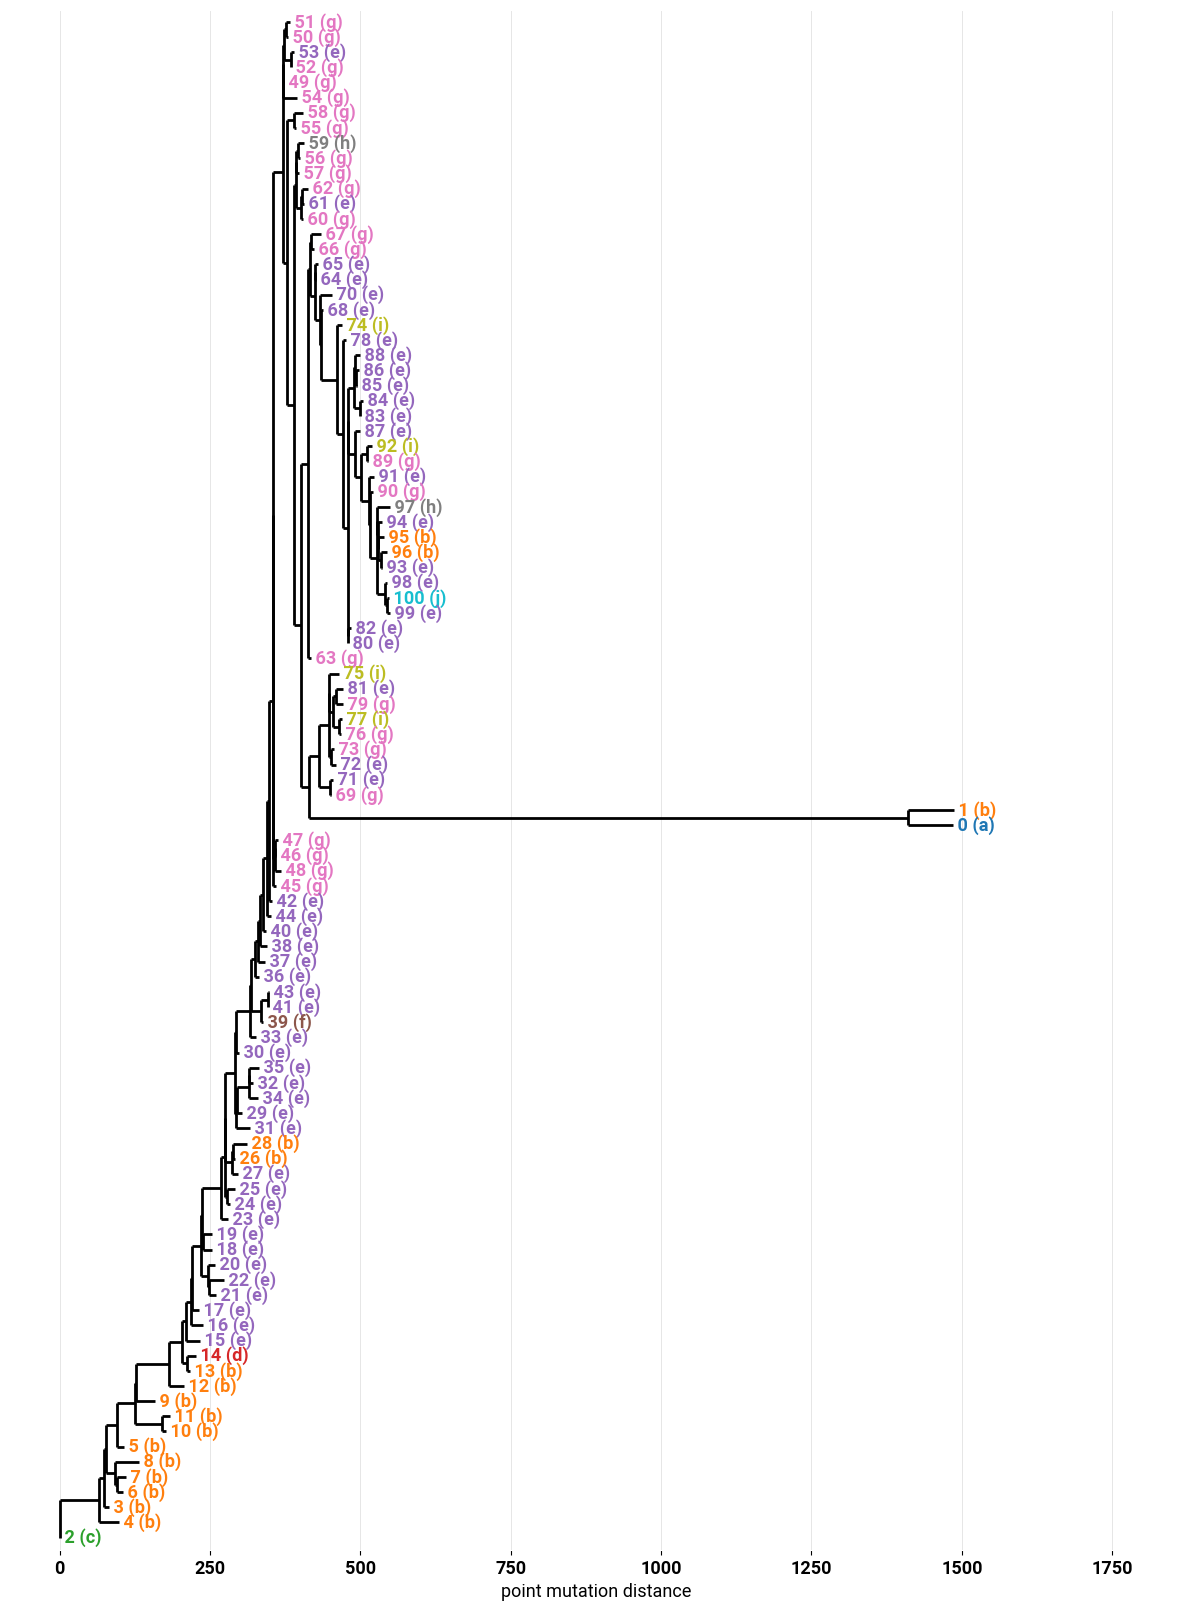

teeplots/./viz=draw+ext=.pdf
teeplots/./viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [48]:
tp.tee(
    Phylo.draw,
    rerooted_pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
#     axhspan=((1, 2), {'facecolor':'gainsboro'}),
)

In [49]:
rerooted_pars_tree

MyTree(rooted=True)
    Clade(branch_length=0)
        MyClade(branch_length=65.7265625, name='Inner4')
            MyClade(branch_length=7.875672043010752, name='Inner5')
                MyClade(branch_length=3.749327956989248, name='Inner7')
                    MyClade(branch_length=17.637907608695656, name='Inner8')
                        MyClade(branch_length=29.67326388888887, name='Inner9')
                            MyClade(branch_length=1.6392361111111313, name='Inner10')
                                MyClade(branch_length=55.25122893258427, name='Inner11')
                                    MyClade(branch_length=22.417295258620697, name='Inner13')
                                        MyClade(branch_length=6.40656795058139, name='Inner14')
                                            MyClade(branch_length=7.851263786764704, name='Inner15')
                                                MyClade(branch_length=2.747535342261898, name='Inner16')
                            

In [50]:
Phylo.write(pars_tree, "pars_tree.xml", "phyloxml")

1